## Modeling with a Long Short-Term Memory Model

In [1]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error


In [4]:

# Load your dataset
data = pd.read_feather('../../data/2.2_temporally_updated_data.feather', columns = ['ArrivalDate', 'ADR'])

# Convert date column to datetime format
data['ArrivalDate'] = pd.to_datetime(data['ArrivalDate'])

# Set the date column as the index
data.set_index('ArrivalDate', inplace=True)

# Generate a list of holidays for Portugal
portugal_holidays = holidays.Portugal(years=range(data.index.min().year, data.index.max().year + 1))

# Create a binary column for holidays
data['is_holiday'] = data.index.to_series().apply(lambda x: 1 if x in portugal_holidays else 0)

# Select the target variable (ADR) and exogenous features
adr = data['ADR'].values.reshape(-1, 1)
exog = data[['is_holiday']].values

# Scale the ADR values
scaler = MinMaxScaler(feature_range=(0, 1))
adr_scaled = scaler.fit_transform(adr)

# Combine ADR and exogenous features for sequence creation
data_scaled = np.hstack((adr_scaled, exog))

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Define time_steps
time_steps = 30

# Create sequences
X, y = create_sequences(data_scaled, time_steps)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Test data shape: {X_test.shape}, {y_test.shape}')


Training data shape: (95488, 30, 2), (95488,)
Test data shape: (23872, 30, 2), (23872,)


In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 9.7418e-05 - val_loss: 7.9312e-05
Epoch 2/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 5.3287e-05 - val_loss: 9.0019e-05
Epoch 3/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 7.1322e-05 - val_loss: 8.1272e-05
Epoch 4/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - loss: 5.2411e-05 - val_loss: 8.6350e-05
Epoch 5/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 5.7014e-05 - val_loss: 7.8936e-05
Epoch 6/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 8.8740e-05 - val_loss: 7.6435e-05
Epoch 7/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 5.5374e-05 - val_loss: 7.6212e-05
Epoch 8/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 4.9843e-05 - val_loss: 8.3918e-05
Epoch 9/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 5.0732e-05 - val_loss: 7.6207e-05
Epoch 10/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 5.3251e-05 - val_loss: 8.0626e-05
Epoch 11/50
2984/29

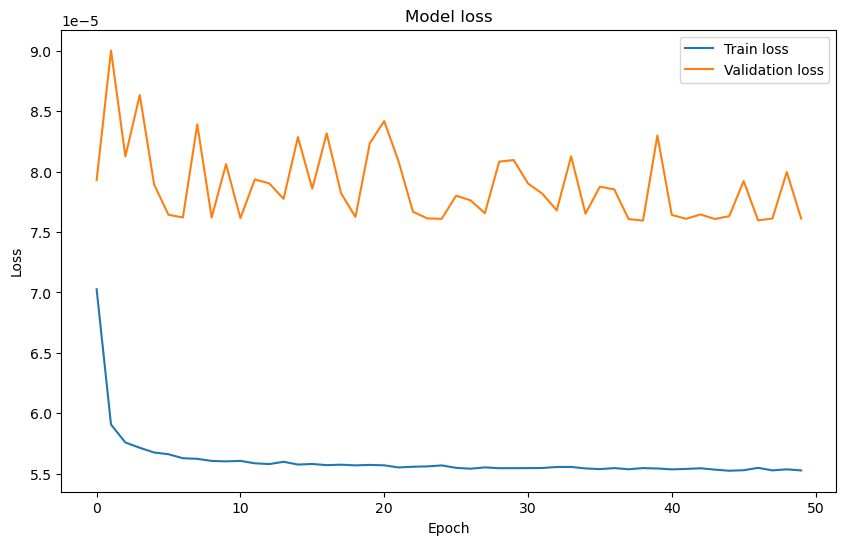

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2984/2984 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
746/746 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training MAE: 26.12
Testing MAE: 34.90
Training MedAE: 19.25
Testing MedAE: 26.36
Training RMSE: 39.84
Testing RMSE: 47.17


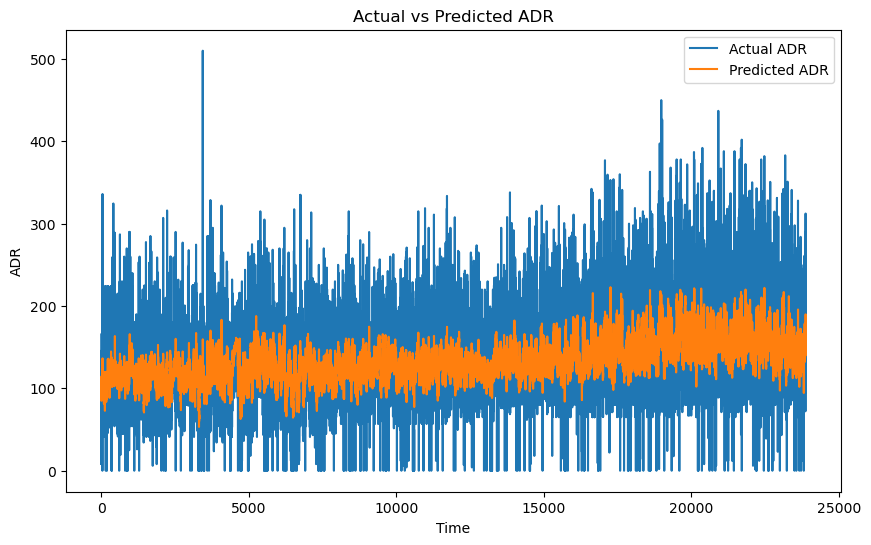

In [9]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
train_medae = median_absolute_error(y_train_actual, y_train_pred)
test_medae = median_absolute_error(y_test_actual, y_test_pred)
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Training MAE: {train_mae:.2f}')
print(f'Testing MAE: {test_mae:.2f}')
print(f'Training MedAE: {train_medae:.2f}')
print(f'Testing MedAE: {test_medae:.2f}')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual ADR')
plt.plot(y_test_pred, label='Predicted ADR')
plt.title('Actual vs Predicted ADR')
plt.xlabel('Time')
plt.ylabel('ADR')
plt.legend()
plt.show()